# First Architecture

This is a simple perceptron architecture with only one layer.

In [117]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load Data

In [2]:
df_train = pd.read_csv('data/raw/lithology.csv', sep=';')
df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,24.735691,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,24.492376,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,24.202299,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,24.400797,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,24.916765,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68


In [3]:
def lithology_number_to_name(x):
    if x == 30000.0:
        return 'Sandstone'
    elif x == 65030.0:
        return 'Sandstone/Shale'
    elif x == 65000.0:
        return 'Shale'
    elif x == 80000.0:
        return 'Marl'
    elif x == 74000.0:
        return 'Dolomite'
    elif x == 70000.0:
        return 'Limestone'
    elif x == 70032.0:
        return 'Chalk'
    elif x == 88000.0:
        return 'Halite'
    elif x == 86000.0:
        return 'Anhydrite'
    elif x == 99000.0:
        return 'Tuff'
    elif x == 90000.0:
        return 'Coal'
    elif x == 93000.0:
        return 'Basement'
    else: raise ValueError('Category Not Found')

df_train = df_train.assign(FORCE_2020_LITHOFACIES_LITHOLOGY_CAT = df_train.FORCE_2020_LITHOFACIES_LITHOLOGY.apply(lambda x: lithology_number_to_name(x)))

df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded,FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Shale
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68,Shale
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68,Shale
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68,Shale
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68,Shale


In [4]:
df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Shale              720803
Sandstone          168937
Sandstone/Shale    150455
Limestone           56320
Marl                33329
Tuff                15245
Chalk               10513
Halite               8213
Coal                 3820
Dolomite             1688
Anhydrite            1085
Basement              103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

In [25]:
def get_values_from_category(df_train, n_samples=1000):
    '''
    Get the same values (or all if it has less than) of all categories. The idea is to balance dataset
    '''

    df_data = pd.DataFrame()

    for cat in df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.unique():
        df_data = df_data.append(df_train[df_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT == cat].iloc[0:n_samples])
    
    return df_data

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded,FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Shale
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68,Shale
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68,Shale
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68,Shale
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68,Shale


In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

def transform_data(X_train, X_test, X_val, y_train, y_test, y_val):
    std = StandardScaler()
    oe = OrdinalEncoder()

    X_train_transform = std.fit_transform(X_train)
    X_test_transform = std.transform(X_test)
    X_val_transform = std.transform(X_val)

    y_train_enc = oe.fit_transform(y_train)
    y_test_enc = oe.transform(y_test)
    y_val_enc = oe.transform(y_val)

    return X_train_transform, X_test_transform, X_val_transform, y_train_enc, y_test_enc, y_val_enc

In [93]:
oe = OrdinalEncoder()
y_train_enc = oe.fit_transform(y_train)

oe.categories_

[array(['Anhydrite', 'Basement', 'Chalk', 'Coal', 'Dolomite', 'Halite',
        'Limestone', 'Marl', 'Sandstone', 'Sandstone/Shale', 'Shale',
        'Tuff'], dtype=object)]

In [103]:
def get_class_distribution(obj):
    count_dict = {
        'Anhydrite': 0, 
        'Basement': 0, 
        'Chalk': 0, 
        'Coal': 0, 
        'Dolomite': 0, 
        'Halite': 0,
        'Limestone': 0, 
        'Marl': 0, 
        'Sandstone': 0, 
        'Sandstone/Shale': 0, 
        'Shale': 0,
        'Tuff': 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Anhydrite'] += 1
        elif i == 1: 
            count_dict['Basement'] += 1
        elif i == 2: 
            count_dict['Chalk'] += 1
        elif i == 3: 
            count_dict['Coal'] += 1
        elif i == 4: 
            count_dict['Dolomite'] += 1  
        elif i == 5: 
            count_dict['Halite'] += 1
        elif i == 6: 
            count_dict['Limestone'] += 1                    
        elif i == 7: 
            count_dict['Marl'] += 1
        elif i == 8: 
            count_dict['Sandstone'] += 1
        elif i == 9: 
            count_dict['Sandstone/Shale'] += 1
        elif i == 10: 
            count_dict['Shale'] += 1
        elif i == 11: 
            count_dict['Tuff'] += 1
        else:
            print("Check classes.")
            
    return count_dict

### Creating a simple model

Model created thanks to this documentation: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [82]:
class SingleLayerSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(SingleLayerSoftmax, self).__init__()
        self.Linear = nn.Linear(n_input, n_output)
    
    def forward(self, x):
        return self.Linear(x)

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

def load_model(
    X_train, X_test, 
    y_train, y_test,
    X_val, y_val, 
    num_epochs=1000, input_size=1, 
    output_size=12, learning_rate=0.05, batch_size=16):
    
    train_dataset = SingleLayerSoftmax(
        torch.from_numpy(X_train.astype(np.float32)), 
        torch.from_numpy(y_train.reshape(-1)).long()
    )

    val_dataset = SingleLayerSoftmax(
        torch.from_numpy(X_val.astype(np.float32)), 
        torch.from_numpy(y_val.reshape(-1)).long()
    )

    test_dataset = SingleLayerSoftmax(
        torch.from_numpy(X_test.astype(np.float32)), 
        torch.from_numpy(y_test.reshape(-1)).long()
    )

    target_list = []
    for _, t in train_dataset:
        target_list.append(t)
    
    target_list = torch.tensor(target_list)
    target_list = target_list[torch.randperm(len(target_list))]

    # Due to unbalanced data, create weights to classes
    class_count = [i for i in get_class_distribution(y_train).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float)

    print(class_weights)

    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    contador_custo = []
    for epoch in range(num_epochs):
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        loss = loss.detach().numpy()

        train_acc = multi_acc(y_hat, y)


        contador_custo.append(loss)
        optimizer.step()
        optimizer.zero_grad()

        # print(f'Epoch {epoch+0:03}: | Train Loss: {loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

        print(f'Epoch {epoch+0:03}: | Train Loss: {loss:.5f} | Train Acc: {train_acc:.3f}')

    print("Cost Graphic")
    plt.plot(contador_custo, 'b')
    plt.show()
    
    # t_teste = torch.from_numpy(teste.astype(np.float32))
    # t_teste = t_teste.view(t_teste.shape[0], 1)

    # with torch.no_grad():
    # predicoes = model(t_teste)
    # print (np.argmax(predicoes, axis=1).flatten())

In [119]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)

class SingleLayerSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(SingleLayerSoftmax, self).__init__()
        self.Linear = nn.Linear(n_input, n_output)
    
    def forward(self, x):
        return self.Linear(x)

#Dataset division: 70:20:10
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    stratify=y_train_val, 
                                                    test_size=0.1,
                                                    random_state=42)

X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, X_val, y_train, y_test, y_val)

train_dataset = ClassifierDataset(
    torch.from_numpy(X_train_transform.astype(np.float32)), 
    torch.from_numpy(y_train_transform.reshape(-1)).long()
)

val_dataset = ClassifierDataset(
    torch.from_numpy(X_val_transform.astype(np.float32)), 
    torch.from_numpy(y_val_transform.reshape(-1)).long()
)

test_dataset = ClassifierDataset(
    torch.from_numpy(X_test_transform.astype(np.float32)), 
    torch.from_numpy(y_test_transform.reshape(-1)).long()
)

target_list = []
for _, t in train_dataset:
    target_list.append(t)

target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

# Due to unbalanced data, create weights to classes
class_count = [i for i in get_class_distribution(y_train_transform).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

print(class_weights)

class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.05
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 12

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=weighted_sampler
)

val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=val_dataset, batch_size=1)

model = SingleLayerSoftmax(NUM_FEATURES, NUM_CLASSES)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optmizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

accuracy_stats = {
    'train': [],
    'val': []
}

loss_stats = {
    'train': [],
    'val': []
}



tensor([0.0014, 0.0137, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014])
SingleLayerSoftmax(
  (Linear): Linear(in_features=30, out_features=12, bias=True)
)


In [ ]:
def process_model(n_samples):
    df_partial_data = get_values_from_category(df_train, n_samples=1000)
    df_partial_data.head()
    df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

    X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
        'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
        'MUDWEIGHT', 'RMIC', 'Carbon_Index',
        'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
        'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
        'FORMATION_encoded']]
    Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

    #Dataset division: 70:20:10
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y,
                                                        stratify=Y, 
                                                        test_size=0.2,
                                                        random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                        stratify=y_train_val, 
                                                        test_size=0.1,
                                                        random_state=42)

    X_train_transform, X_test_transform, X_val_transform, y_train_transform, y_test_transform, y_val_transform = transform_data(X_train, X_test, y_train, y_test)

    load_model(
        X_train_transform, X_test_transform, 
        y_train_transform, y_test_transform,
        input_size=30, num_epochs=1000)

## Tests

### Test 1, 1000 samples per class in a simple model

5.000
Epoch 623: | Train Loss: 0.52738 | Train Acc: 85.000
Epoch 624: | Train Loss: 0.52709 | Train Acc: 85.000
Epoch 625: | Train Loss: 0.52681 | Train Acc: 85.000
Epoch 626: | Train Loss: 0.52653 | Train Acc: 85.000
Epoch 627: | Train Loss: 0.52625 | Train Acc: 85.000
Epoch 628: | Train Loss: 0.52597 | Train Acc: 85.000
Epoch 629: | Train Loss: 0.52569 | Train Acc: 85.000
Epoch 630: | Train Loss: 0.52541 | Train Acc: 85.000
Epoch 631: | Train Loss: 0.52514 | Train Acc: 85.000
Epoch 632: | Train Loss: 0.52486 | Train Acc: 85.000
Epoch 633: | Train Loss: 0.52458 | Train Acc: 85.000
Epoch 634: | Train Loss: 0.52430 | Train Acc: 85.000
Epoch 635: | Train Loss: 0.52403 | Train Acc: 85.000
Epoch 636: | Train Loss: 0.52375 | Train Acc: 85.000
Epoch 637: | Train Loss: 0.52348 | Train Acc: 85.000
Epoch 638: | Train Loss: 0.52321 | Train Acc: 85.000
Epoch 639: | Train Loss: 0.52293 | Train Acc: 85.000
Epoch 640: | Train Loss: 0.52266 | Train Acc: 85.000
Epoch 641: | Train Loss: 0.52239 | Train

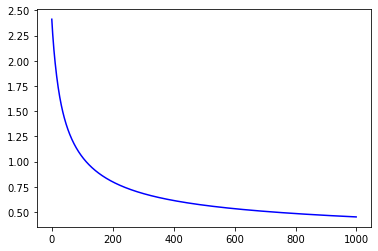

In [83]:
process_model(n_samples=1000)

### Test 2, 5000 samples per class in a simple model

Sandstone/Shale    5000
Sandstone          5000
Halite             5000
Marl               5000
Tuff               5000
Chalk              5000
Shale              5000
Limestone          5000
Coal               3820
Dolomite           1688
Anhydrite          1085
Basement            103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
Cost Graphic


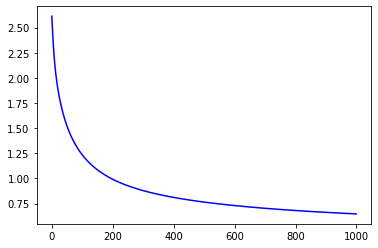

In [76]:
df_partial_data = get_values_from_category(df_train, n_samples=5000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'Carbon_Index',
       'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
       'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
       'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]


X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.25,
                                                    random_state=42)

X_train_transform, X_test_transform, y_train_transform, y_test_transform = transform_data(X_train, X_test, y_train, y_test)

load_model(
    X_train_transform, X_test_transform, 
    y_train_transform, y_test_transform,
    input_size=30, num_epochs=1000)

### Test 3, 10000 samples in a simple model

Sandstone/Shale    10000
Marl               10000
Chalk              10000
Limestone          10000
Sandstone          10000
Tuff               10000
Shale              10000
Halite              8213
Coal                3820
Dolomite            1688
Anhydrite           1085
Basement             103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64
Cost Graphic


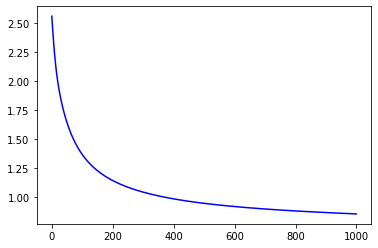

In [77]:
df_partial_data = get_values_from_category(df_train, n_samples=10000)
df_partial_data.head()
print(df_partial_data.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts())

X = df_partial_data[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'Carbon_Index',
       'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
       'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
       'FORMATION_encoded']]
Y = df_partial_data[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]


X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.25,
                                                    random_state=42)

X_train_transform, X_test_transform, y_train_transform, y_test_transform = transform_data(X_train, X_test, y_train, y_test)

load_model(
    X_train_transform, X_test_transform, 
    y_train_transform, y_test_transform,
    input_size=30, num_epochs=1000)

In [ ]:
class SingleLayerSoftmax(nn.Module):
    def __init__(self, n_input, n_output):
        super(SingleLayerSoftmax, self).__init__()
        self.Linear = nn.Linear(n_input, n_output)
    
    def forward(self, x):
        return self.Linear(x)

def load_model_backup(
    X_train, X_test, 
    y_train, y_test,
    num_epochs=1000, input_size=1, 
    output_size=12, learning_rate=0.05):

    x = torch.from_numpy(X_train.astype(np.float32))
    y = torch.from_numpy(y_train.reshape(-1).astype(np.float32))
    y = y.long()
    x = x.view(x.shape[0], input_size)    

    model = SingleLayerSoftmax(input_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    contador_custo = []
    for epoch in range(num_epochs):
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        loss = loss.detach().numpy()

        train_acc = multi_acc(y_hat, y)


        contador_custo.append(loss)
        optimizer.step()
        optimizer.zero_grad()

        # print(f'Epoch {epoch+0:03}: | Train Loss: {loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

        print(f'Epoch {epoch+0:03}: | Train Loss: {loss:.5f} | Train Acc: {train_acc:.3f}')

    print("Cost Graphic")
    plt.plot(contador_custo, 'b')
    plt.show()
    
    # t_teste = torch.from_numpy(teste.astype(np.float32))
    # t_teste = t_teste.view(t_teste.shape[0], 1)

    # with torch.no_grad():
    # predicoes = model(t_teste)
    # print (np.argmax(predicoes, axis=1).flatten())